https://zaynmak.github.io/posts/Allocative-Bias/bias.html

In [4]:
from folktables import ACSDataSource, ACSEmployment, BasicProblem, adult_filter
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier

np.random.seed(0)

In [5]:
STATE = "MA"

data_source = ACSDataSource(survey_year='2018', 
                            horizon='1-Year', 
                            survey='person')

acs_data = data_source.get_data(states=[STATE], download=True)

In [6]:
possible_features=['AGEP', 'SCHL', 'MAR', 'RELP', 'DIS', 'ESP', 'CIT', 'MIG', 'MIL', 'ANC', 'NATIVITY', 'DEAR', 'DEYE', 'DREM', 'SEX', 'RAC1P', 'ESR']
acs_data[possible_features].head()

,AGEP,SCHL,MAR,RELP,DIS,ESP,CIT,MIG,MIL,ANC,NATIVITY,DEAR,DEYE,DREM,SEX,RAC1P,ESR
0,77,19.0,3,16,2,NaN,1,3.0,4.0,1,1,2,2,2.0,2,1,6.0
1,18,18.0,5,17,2,NaN,1,1.0,4.0,2,1,2,2,2.0,2,9,1.0
2,28,21.0,5,17,2,NaN,1,1.0,4.0,2,1,2,2,2.0,1,1,1.0
3,22,19.0,5,17,2,NaN,1,1.0,4.0,1,1,2,2,2.0,1,1,6.0
4,50,1.0,5,17,1,NaN,1,1.0,4.0,1,1,2,1,1.0,2,1,6.0


In [7]:
features_to_use = [f for f in possible_features if f not in ["ESR", "RAC1P"]]

EmploymentProblem = BasicProblem(
    features=features_to_use,
    target='ESR',
    target_transform=lambda x: x == 1,
    group='RAC1P',
    preprocess=lambda x: x,
    postprocess=lambda x: np.nan_to_num(x, -1),
)

features, label, group = EmploymentProblem.df_to_numpy(acs_data)

In [8]:
X_train, X_test, y_train, y_test, group_train, group_test = train_test_split(
    features, label, group, test_size=0.2, random_state=0)

In [9]:
model = make_pipeline(StandardScaler(), LogisticRegression())
model.fit(X_train, y_train)
y_hat = model.predict(X_test)
tot_acc = (y_hat == y_test).mean()
white_acc = (y_hat == y_test)[group_test == 1].mean()
black_acc = (y_hat == y_test)[group_test == 2].mean()
print(f"Total accuracy: {tot_acc}")
print(f"The accuracy for white individuals: {white_acc}")
print(f"The accuracy for black individuals: {black_acc}")

Total accuracy: 0.7803521779425394
The accuracy for white individuals: 0.7833114897335081
The accuracy for black individuals: 0.7806122448979592


Total number of individuals: 56104
Proportion of individuals with target label equal to 1: 0.5056858691002424
Number of individuals in each group: group
1    45515
2     3405
3       66
4        1
5       24
6     3778
7       24
8     1698
9     1593
Name: label, dtype: int64
Proportion of individuals with target label equal to 1 in each group: group
1    0.514556
2    0.456681
3    0.500000
4    1.000000
5    0.500000
6    0.510058
7    0.625000
8    0.469376
9    0.383553
Name: label, dtype: float64


[Text(0, 0, 'White'), Text(1, 0, 'Black'), Text(2, 0, 'Asian')]

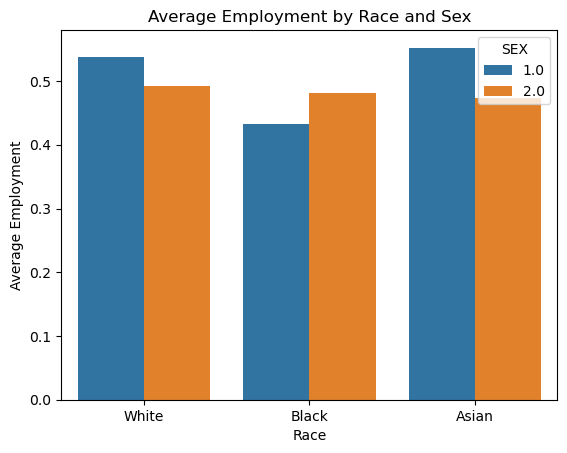

In [10]:
df = pd.DataFrame(X_train, columns = features_to_use)
df["group"] = group_train
df["label"] = y_train

print(f"Total number of individuals: {len(df)}")
print(f"Proportion of individuals with target label equal to 1: {df['label'].mean()}")
print(f"Number of individuals in each group: {df.groupby('group')['label'].count()}")
print(f"Proportion of individuals with target label equal to 1 in each group: {df.groupby('group')['label'].mean()}")

# only looking at white, black, and asian individuals because of small sample size of other races
race_list = [1, 2, 6]
filtered = df.query("group in @race_list")

# group by race and sex then check employment
grouped = filtered.groupby(['group', 'SEX'])['label'].mean().reset_index()

races = ["White", "Black", "Asian",]

plot = sns.barplot(data= grouped, x='group', y='label', hue='SEX')
plot.set(title="Average Employment by Race and Sex", xlabel="Race", ylabel="Average Employment")
plot.set_xticklabels(races)


We see that white, black, and asian women all have about the same average employment rate of 49%. Meanwhile white and asian men have an average employment rate of 54%, while black men have the lowest average employment rate among these 6 groups at 43%.

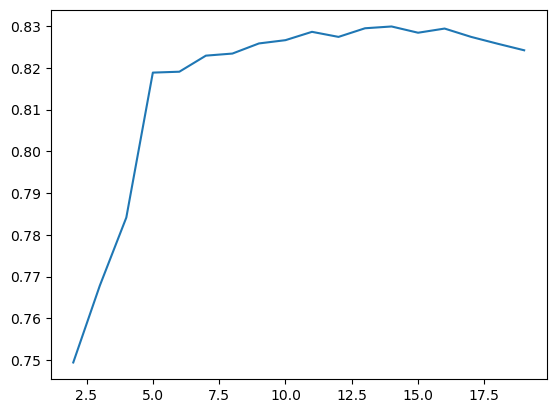

In [11]:
accuracies = []

for i in range(2, 20):
    RF = RandomForestClassifier(n_estimators=100, max_depth=i, random_state=0)
    RF.fit(X_train, y_train)
    y_hat = RF.predict(X_test)
    accuracies.append((y_hat == y_test).mean())

plt.plot(range(2, 20), accuracies)

Looking at the plot, it seems like the best choice for max depth is 14, because after that the accuracy does start to decrease. However it is only slightly more accurate than a max depth of 5, but will take longer to run.

In [ ]:
# Recaculate with max_depth = 16
RF = RandomForestClassifier(n_estimators=100, max_depth=16, random_state=0)
RF.fit(X_train, y_train)
y_hat = RF.predict(X_test)

In [43]:
print(f"Total accuracy: {(y_hat == y_test).mean()}")

# positive predictive value (PPV) of your model
(tn, fp), (fn, tp) = confusion_matrix(y_test, y_hat)
ppv = tp / (tp + fp)
print(f"Positive predictive value: {ppv}")

# false negative rate (FNR) of your model
fnr = fn / (fn + tp)
print(f"False negative rate: {fnr}")

# false positive rate (FPR) of your model
fpr = fp / (fp + tn)
print(f"False positive rate: {fpr}")

# in a table
races = ["White", "Black", "American Indian", "American Indian and Alaska Native", "Asian", "Native Hawaiian"]
columns = ["Accuracy", "PPV", "FNR", "FPR", "Prediction Rate"]
datf = pd.DataFrame(columns=columns, index=races)
results = [[], [], [], [], []]

# accuracy of your model on each subgroup
[results[0].append((y_hat == y_test)[group_test == i].mean()) for i in range(1, 8) if i != 4]

# PPV of your model on each subgroup
for i in range(1, 8):
    if i != 4:
        tn, fp, fn, tp = confusion_matrix(y_test[group_test == i], y_hat[group_test == i]).ravel()
        ppv = tp / (tp + fp)
        results[1].append(ppv)


# FNR of your model on each subgroup
for i in range(1, 8):
    if i != 4:
        tn, fp, fn, tp = confusion_matrix(y_test[group_test == i], y_hat[group_test == i]).ravel()
        fnr = fn / (fn + tp)
        results[2].append(fnr)

# FPR of your model on each subgroup
for i in range(1, 8):
    if i != 4:
        tn, fp, fn, tp = confusion_matrix(y_test[group_test == i], y_hat[group_test == i]).ravel()
        fpr = fp / (fp + tn)
        results[3].append(fpr)

# predictions for each group
for i in range(1,8):
    if i != 4:
        results[4].append(y_hat[group_test == i].mean())

for i in range(5):
    datf[columns[i]] = results[i]
datf.head()


Total accuracy: 0.8294004420047052
Positive predictive value: 0.7998197734294542
False negative rate: 0.11884839029924833
False positive rate: 0.22290711009174313


,Accuracy,PPV,FNR,FPR,Prediction Rate
White,0.830756,0.806017,0.119630,0.220993,0.557623
Black,0.822704,0.792363,0.135417,0.217500,0.534439
American Indian,0.882353,0.750000,0.000000,0.181818,0.470588
American Indian and Alaska Native,0.666667,0.750000,0.571429,0.125000,0.266667
Asian,0.813928,0.758095,0.099548,0.266247,0.571273


There was only one observation for Alaska Native group, so it was removed from the results.

#### Bias Measures
To be calibrated, the score threshold should be the same for all samples  in the dataset. Since that is the case here, my model is calibrated.

The three largest groups consisting of white, black, and asian individuals have similar FNR at ~11±2% and FPR at ~22% (with asian individuals at ~27%), however most of the other groups that have non-zero results have a much higher FNR and lower FPR. This means that there is some error rate imbalance in my model.

Most of my predictions rates are within 10% except for American Indian and Alaska Native. This means that my model does not satisfy statistical parity.

#### Concluding Discussion
The groups of people that could benefit from a system that is able to predict the label I predicted are people who are looking for a job, and companies that are looking to hire people. This model could be used to predict whether or not someone is employed, and if they are not, it could be used to predict whether or not they will be employed in the future. This could be used by companies to determine whether or not they should hire someone, and it could be used by people to determine whether or not they should apply for a job.

Deploying this model for large-scale prediction in commercial or governmental settings could lead to a lot of people not getting jobs that they should have gotten, and a lot of people getting jobs that they should not have gotten. This could lead to a lot of people being unemployed that should not be, and a lot of people being employed that should not be. This could lead to a lot of people being unhappy, and a lot of companies being unhappy. This is exarcerbated for American Indian and Alaska Native who have a very high FNR (57%) and very low FPR (12%).

My model definitely displays problematic bias. Although it is calibrated, it has error rate imbalance and does not satisfy statistical parity.

Outside of the bias, I think that this model could be used to discriminate against people who are unemployed. I think that this could be addressed by making sure that the model is only used to predict whether or not someone will be employed in the future.